In [1]:
from pathlib import Path
import numpy as np 
from PIL import Image

import pandas as pd
from pandas.plotting import parallel_coordinates
import matplotlib.pyplot as plt
import seaborn as sns

import utils
sns.set(style="whitegrid")

In [2]:
CLASSES = ['Healthy', 'OC Degeneration']
input_stages = {'0': 'training', '1': 'validation_nodiag', '2': 'validation_noxai'}
BASEPATH = Path('/Users/djohnson/sciebo/1. Research/1. HCXAI/1. Projects/evalxai_studies/example_validation_study')

In [3]:
def get_id(res_file: Path):
    return res_file.stem.split('_')[-1]

# ids from final stage to ensure completion
ids = [get_id(f) for f in (BASEPATH / 'validation_noxai/results').rglob('*.csv') if 'dj'  in get_id(f)]
ids.remove('djnew')
ids

['djnw2']

In [4]:
dfs_1 = {id: pd.read_csv(BASEPATH / input_stages['1'] / 'results' / f'results_{input_stages["1"]}_{id}.csv') for id in ids}
dfs_2 = {id: pd.read_csv(BASEPATH / input_stages['2'] / 'results' / f'results_{input_stages["2"]}_{id}.csv') for id in ids}

In [5]:
def get_results(df, stage):
    acc = (df['true'] == df['select']).astype(int).mean()

    # stage one only has an accuracy value sine there is no AI
    if stage == '1':
       return acc
    
    agree_cond = df['pred'] == df['select']
    disagree_cond = df['pred'] != df['select']

    correct_preds = (df['pred'] == df['true'])
    incorrect_preds = (df['pred'] != df['true'])  

    # overreliance
    or_cond = agree_cond & incorrect_preds
    overreliance = (or_cond).astype(int).sum() / incorrect_preds.astype(int).sum()

    ur_cond = disagree_cond & correct_preds
    underreliance = (ur_cond).astype(int).sum() / correct_preds.astype(int).sum()

    # agreement
    reliance = (agree_cond).astype(int).sum() / len(df)
    
    # disagreement
    disagree = (disagree_cond).astype(int).sum() / len(df)

    # healthy distrust (prev. approp. reliance)
    hdt_cond = disagree_cond & incorrect_preds
    h_distrust = (hdt_cond).astype(int).sum() / (incorrect_preds).astype(int).sum()

    # health trust
    ht_cond = agree_cond & correct_preds
    h_trust = (ht_cond).astype(int).sum() / (correct_preds).astype(int).sum()

    return acc, reliance, overreliance, underreliance, disagree, h_distrust, h_trust


In [6]:
# columns = ['id', 'accuracy1', 'accuracy2', 'reliance2', 'overreliance2', 'disagreement2', 'appropriate_reliance2']
dfs = []
for (id1, df1), (id2, df2) in zip(dfs_1.items(), dfs_2.items()):
    assert id1 == id2, 'IDs do not match'

    acc1 = get_results(df1, stage='1')
    acc2, reliance2, overreliance2, underreliance2, disagree2, h_distrust2, h_trust2 = get_results(df2, stage='2')

    results = dict(
        id = id1,
        accuracy1 = acc1, 
        accuracy2 = acc2, 
        reliance2 = reliance2,
        overreliance2 = overreliance2,
        underreliance2 = underreliance2,
        healthy_distrust2 = h_distrust2,
        healthy_trust2 = h_trust2
    )

    dfs.append(pd.DataFrame([results]))

df = pd.concat(dfs, ignore_index=True)
df.set_index('id', inplace=True)
df

,accuracy1,accuracy2,reliance2,overreliance2,underreliance2,healthy_distrust2,healthy_trust2
id,,,,,,,
djnw2,0.761905,0.809524,0.809524,0.5,0.035714,0.5,0.964286


In [7]:
df.describe()

,accuracy1,accuracy2,reliance2,overreliance2,underreliance2,healthy_distrust2,healthy_trust2
count,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.000000
mean,0.761905,0.809524,0.809524,0.5,0.035714,0.5,0.964286
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.761905,0.809524,0.809524,0.5,0.035714,0.5,0.964286
25%,0.761905,0.809524,0.809524,0.5,0.035714,0.5,0.964286
50%,0.761905,0.809524,0.809524,0.5,0.035714,0.5,0.964286
75%,0.761905,0.809524,0.809524,0.5,0.035714,0.5,0.964286
max,0.761905,0.809524,0.809524,0.5,0.035714,0.5,0.964286


In [8]:
medians = df.median()
medians

accuracy1            0.761905
accuracy2            0.809524
reliance2            0.809524
overreliance2        0.500000
underreliance2       0.035714
healthy_distrust2    0.500000
healthy_trust2       0.964286
dtype: float64

/var/folders/cn/w2dpgz0941bcbfg3wgqzyr6c0000gn/T/ipykernel_99294/1505865982.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(tick_labels)


(-0.1, 1.1)

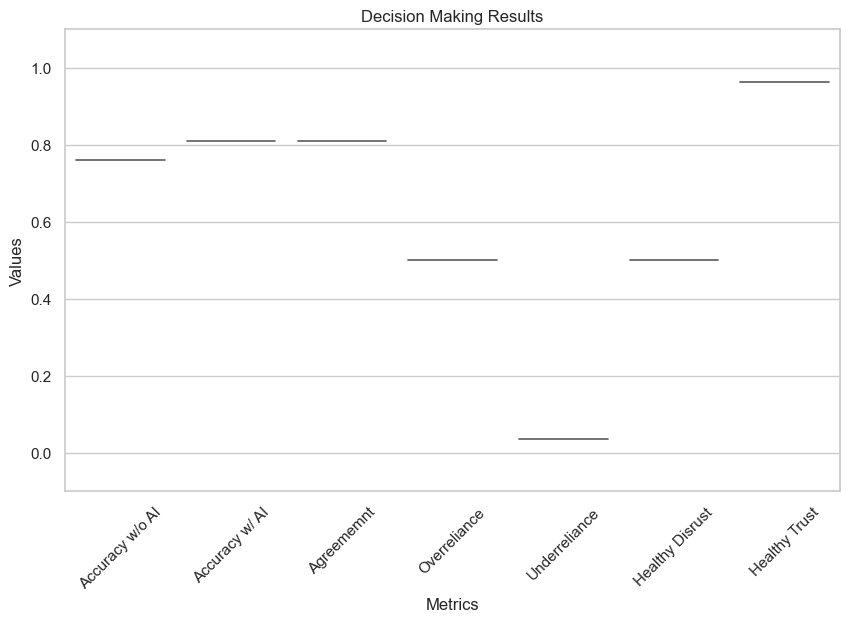

In [9]:
tick_labels = ['Accuracy w/o AI', 'Accuracy w/ AI', 'Agreememnt', 'Overreliance', 'Underreliance',  'Healthy Disrust', 'Healthy Trust']
plt.figure(figsize=(10, 6))
ax = sns.violinplot(data=df, inner='box', palette='Set3')  # Set inner=None to remove bars

df_tmp = df[['accuracy1', 'accuracy2']]
# for index, row in df_tmp.iterrows():
#   plt.plot(df_tmp.columns, row, marker='o', label=f'ID {index}')

plt.title('Decision Making Results')
plt.xlabel('Metrics')
plt.ylabel('Values')
ax.set_xticklabels(tick_labels)
plt.xticks(rotation = 45)

plt.ylim([-0.1, 1.1])
# plt.legend()

/var/folders/cn/w2dpgz0941bcbfg3wgqzyr6c0000gn/T/ipykernel_99294/1887224819.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(tick_labels)


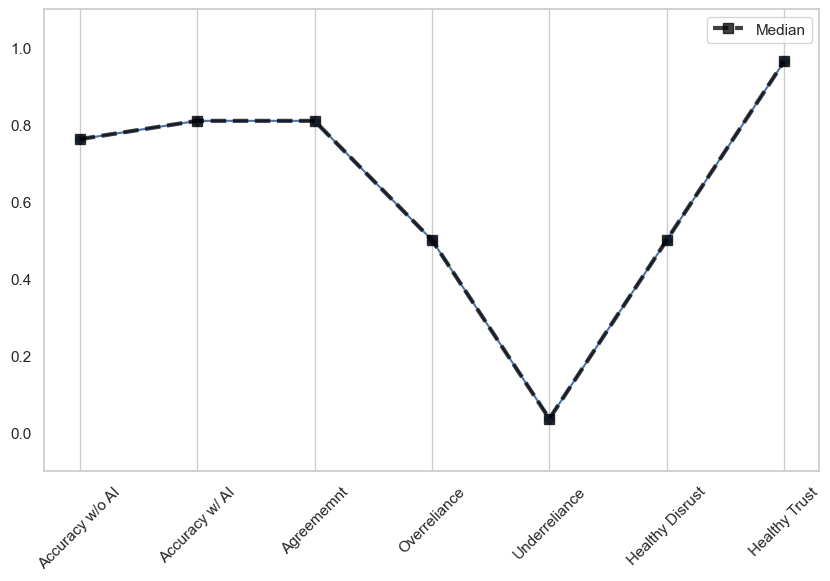

In [10]:
# Create a line plot for each row
plt.figure(figsize=(10, 6))  # Set the figure size


# Plot each row's values as a separate line
for index, row in df.iterrows():
  plt.plot(df.columns, row, marker='o')

plt.plot(df.columns, medians, marker='s', label=f'Median', linestyle='--', linewidth=3, color='black', alpha=0.75, markersize=7)

ax = plt.gca()
ax.set_xticklabels(tick_labels)
plt.xticks(rotation = 45)
ax.grid(False, axis='y')

plt.ylim([-0.1, 1.1])
plt.legend()

/Users/djohnson/micromamba/envs/evalxai_studies_new/lib/python3.10/site-packages/seaborn/axisgrid.py:1639: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_k = hue_grouped.get_group(label_k)
/Users/djohnson/micromamba/envs/evalxai_studies_new/lib/python3.10/site-packages/seaborn/axisgrid.py:1639: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_k = hue_grouped.get_group(label_k)
/Users/djohnson/micromamba/envs/evalxai_studies_new/lib/python3.10/site-packages/seaborn/axisgrid.py:1639: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  da

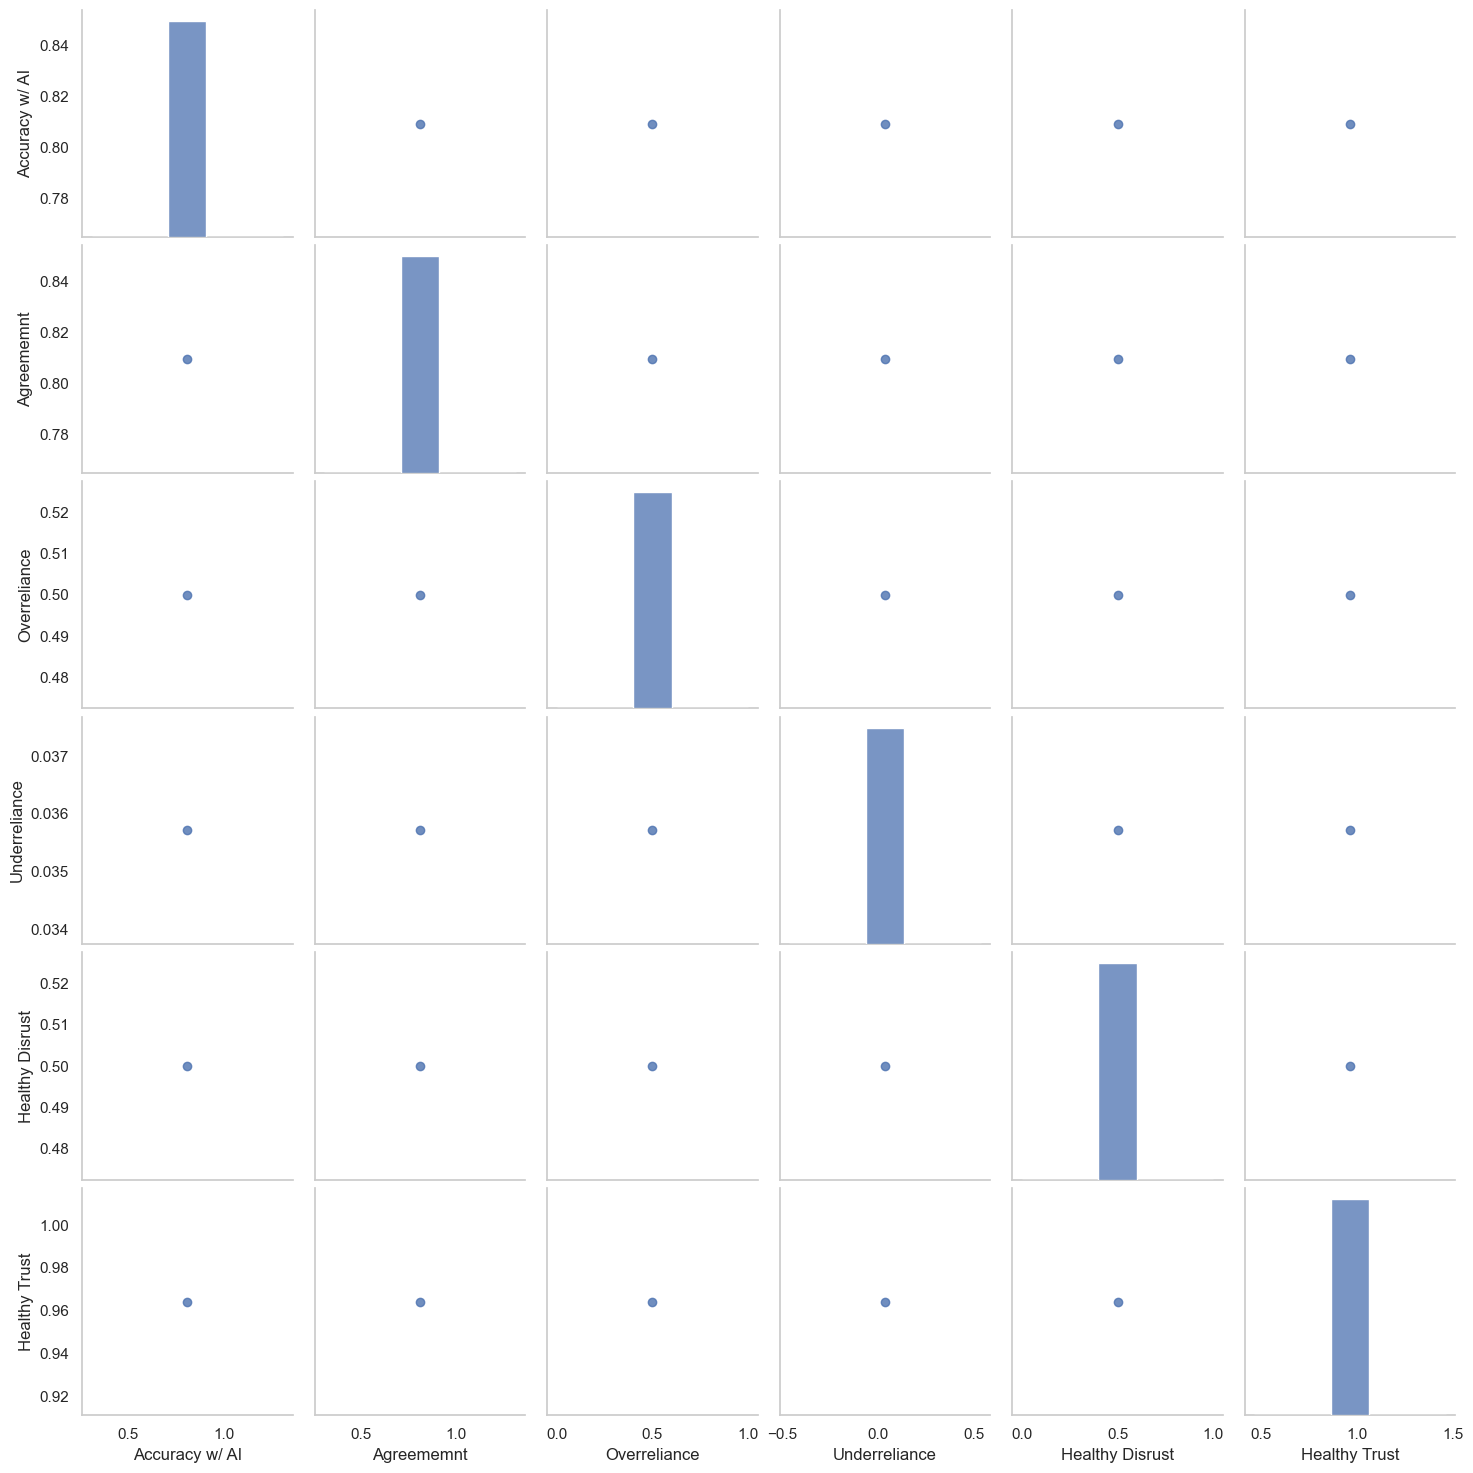

In [11]:
labels = tick_labels[1:]
df_tmp = df.drop(columns=['accuracy1'])
axes = sns.pairplot(df_tmp, kind='reg', diag_kind='hist', diag_kws={'bins': 5})
# Disable grid for each axis in the pair plot
for ax in axes.axes.flat:
    ax.grid(False)

for i, ax_row in enumerate(axes.axes):
  for j, ax in enumerate(ax_row):
    if j == 0:
      ax.set_ylabel(labels[i])
    if i == len(axes.axes) - 1:
      ax.set_xlabel(labels[j])


In [12]:
df.describe()

,accuracy1,accuracy2,reliance2,overreliance2,underreliance2,healthy_distrust2,healthy_trust2
count,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.000000
mean,0.761905,0.809524,0.809524,0.5,0.035714,0.5,0.964286
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.761905,0.809524,0.809524,0.5,0.035714,0.5,0.964286
25%,0.761905,0.809524,0.809524,0.5,0.035714,0.5,0.964286
50%,0.761905,0.809524,0.809524,0.5,0.035714,0.5,0.964286
75%,0.761905,0.809524,0.809524,0.5,0.035714,0.5,0.964286
max,0.761905,0.809524,0.809524,0.5,0.035714,0.5,0.964286


In [13]:
for id1, df1 in dfs_1.items():
    df1['userid'] = id1

for id2, df2 in dfs_2.items():
    df2['userid'] = id2

df_noai = pd.concat(dfs_1.values())
df_ai = pd.concat(dfs_2.values())

In [14]:
df_noai

,id,true,pred,select,userid
0,530c9246-31e8-4fed-9192-aa0fa3017764,1,1,1,djnw2
1,8e965ce6-e1fd-406b-ae1c-bc84848a27b3,1,1,1,djnw2
2,a1ba56c2-c4a3-4154-a81b-c9ba105f47fc,0,0,0,djnw2
3,e913fdfa-4c72-4d1b-bec6-728f7acece8b,0,0,0,djnw2
4,10a24dec-c7d7-4169-9a4e-a34fcb69119b,0,0,0,djnw2
5,70a47849-b4d0-43ec-b4af-1c22f6b31f27,1,1,1,djnw2
6,75c4fe9d-a8d0-45cf-9796-71033e292b9b,1,1,1,djnw2
7,078daae8-cf83-48b2-aedd-bd212440aa61,0,0,0,djnw2
8,d3c808a5-0947-4454-ae76-c27839ea00b3,0,0,0,djnw2
9,7a515406-c071-4d5c-aac0-af19ce8cb98f,0,0,1,djnw2


In [15]:
df_ai

,id,true,pred,select,userid
0,d7018f57-9c6b-4bc1-aab9-15ef48090150,1,1,1,djnw2
1,acf68137-b6f7-4840-a6b7-fd0881817341,0,0,0,djnw2
2,10a24dec-c7d7-4169-9a4e-a34fcb69119b,0,0,0,djnw2
3,a1ba56c2-c4a3-4154-a81b-c9ba105f47fc,0,0,0,djnw2
4,530c9246-31e8-4fed-9192-aa0fa3017764,1,1,1,djnw2
5,0e140205-91a5-4537-b9e6-c9c7af7e62cf,1,1,1,djnw2
6,078daae8-cf83-48b2-aedd-bd212440aa61,0,0,0,djnw2
7,19c24725-f6d0-4166-8293-642937e55cce,0,0,0,djnw2
8,f2ad41b2-29f0-4dfb-ab6f-db947bafe2c2,0,1,1,djnw2
9,8058f4e5-22a0-48c0-8cb6-c5d62a9b27b4,1,0,1,djnw2


In [16]:
get_results(df_ai, stage=2)

(0.8095238095238095,
 0.8095238095238095,
 0.5,
 0.03571428571428571,
 0.19047619047619047,
 0.5,
 0.9642857142857143)

In [17]:
agree_cond = df_ai['pred'] == df_ai['select']
disagree_cond = df_ai['pred'] != df_ai['select']

correct_preds = (df_ai['pred'] == df_ai['true'])
incorrect_preds = (df_ai['pred'] != df_ai['true'])

or_cond = incorrect_preds & agree_cond
ur_cond = correct_preds & disagree_cond

ht_cond = agree_cond & correct_preds
hd_cond = disagree_cond & incorrect_preds

ht_cond.astype(int).sum(), hd_cond.astype(int).sum(), or_cond.astype(int).sum(), ur_cond.astype(int).sum()

(27, 7, 7, 1)

In [18]:
df_or = df_ai[or_cond]['id'].value_counts().reset_index()
df_ur = df_ai[ur_cond]['id'].value_counts().reset_index()
df_hd = df_ai[hd_cond]['id'].value_counts().reset_index()
df_ht = df_ai[ht_cond]['id'].value_counts().reset_index()

In [25]:
gdrive = Path('/Users/djohnson/Library/CloudStorage/GoogleDrive-fortjay81@gmail.com/My Drive')
samples_path = gdrive / 'hcxai/blockies/oc_degeneration_original/original_input/pytorch_model'



xai_samples_csv = samples_path / '2024-11-22/xai_samples/xai_samples_df.csv'
df_xai_samples = pd.read_csv(xai_samples_csv )

In [26]:
# (or setup own data location if prefered)
data_dir_sickones = utils.download_file(url="https://uni-bielefeld.sciebo.de/s/AIJLvXMwP0ngEiW/download",
                               file_name="two4two_datasets.tar.gz",
                               cache_dir= '../data',
                               extract=False,
                               force_download=False,
                               archive_folder='two4two_datasets')
data_dir_sickones

File already exists at: ../data/two4two_datasets.tar.gz
File already extracted to: ../data/two4two_datasets


PosixPath('../data/two4two_datasets')

In [27]:
nobias_dir = data_dir_sickones.with_suffix('').with_suffix('') / 'sick_ones_bendbias'
nobias_dir

PosixPath('../data/two4two_datasets/sick_ones_bendbias')

In [28]:
def get_image(id):
  f_path = nobias_dir / 'test' / df_xai_samples.loc[df_xai_samples.id == id, 'filename'].values[0]
  image = np.array(Image.open(f_path).convert('RGB')) * 1. / 255
  return image

In [29]:
df_or

,id,count
0,f2ad41b2-29f0-4dfb-ab6f-db947bafe2c2,1
1,116fce59-1bf1-4c6d-8962-b379f85ee851,1
2,53399d46-303d-4fa7-a3b6-a4238387ff45,1
3,4a5310d9-7318-4402-8d7c-c323c256227c,1
4,afba37e1-a57f-4a53-a4db-1ad537d531bf,1
5,2cfad545-d9df-4d30-8671-5a5c282f09a5,1
6,356c8c17-7c16-444a-ad9c-496397b03c28,1


In [30]:
most_or_images = df_or[df_or['count'] > 0]
imgs = {s.id: get_image(s.id) for _, s in most_or_images.iterrows()}
len(imgs)

7

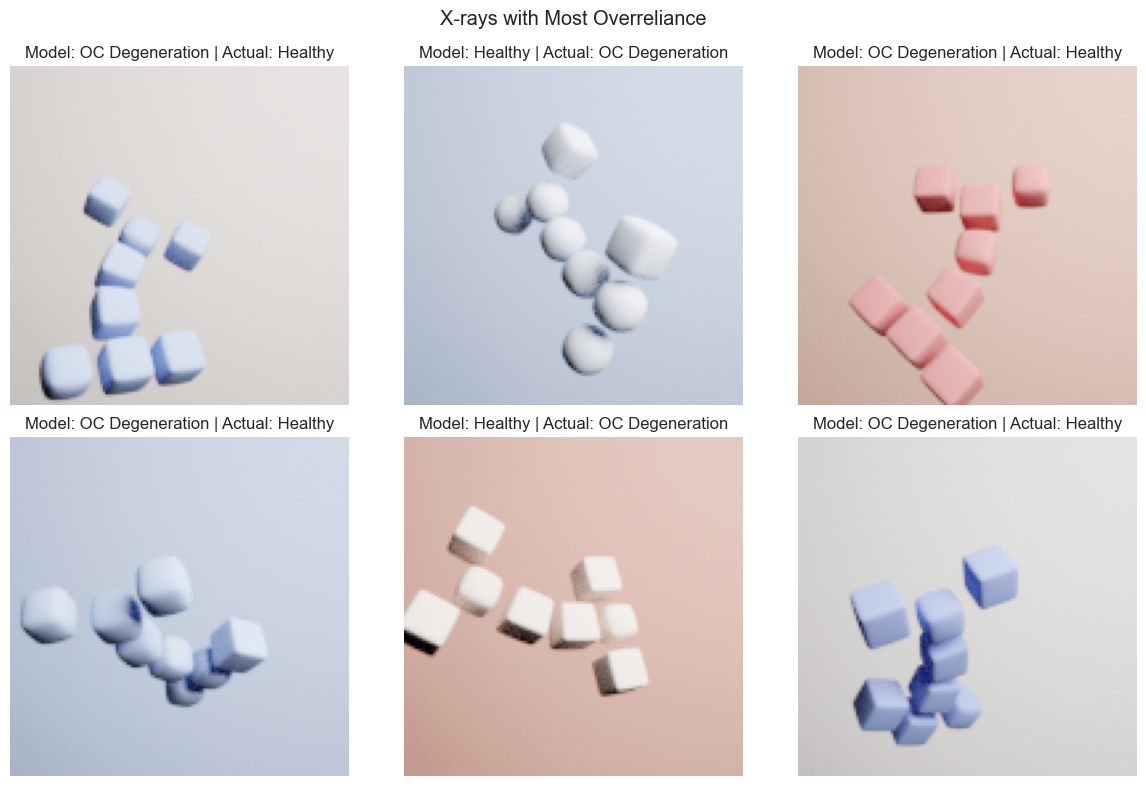

In [31]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for ax, (id, img) in zip(axes.flatten(), imgs.items()):
    ax.imshow(img)
    # user = df_xai_samples[df_xai_samples['id'] == id]['select']
    model = CLASSES[df_xai_samples.loc[df_xai_samples['id'] == id, 'pred'].values[0]]
    actual = CLASSES[df_xai_samples.loc[df_xai_samples['id'] == id, 'ill'].values[0]]
    ax.set_title(f'Model: {model} | Actual: {actual}')
    ax.axis('off')
plt.suptitle('X-rays with Most Overreliance')
plt.tight_layout()

In [32]:
df_ai_sorted = df_ai.sort_values(by=['id', 'userid'], ignore_index=True)
df_noai_sorted = df_noai.sort_values(by=['id', 'userid'], ignore_index=True)

flipped_df = df_ai_sorted[df_ai_sorted['select'] != df_noai_sorted['select']]

inc_cond = flipped_df['pred'] != flipped_df['true']
agg_cond = flipped_df['pred'] == flipped_df['select']
or_cond_f = inc_cond & agg_cond

flipped_df[or_cond_f]

,id,true,pred,select,userid


In [34]:
flipped_df

,id,true,pred,select,userid
8,22a61179-0833-49c7-ab69-96dc1ce0ee2d,1,0,1,djnw2
19,7a515406-c071-4d5c-aac0-af19ce8cb98f,0,0,0,djnw2
20,8058f4e5-22a0-48c0-8cb6-c5d62a9b27b4,1,0,1,djnw2
39,e913fdfa-4c72-4d1b-bec6-728f7acece8b,0,0,1,djnw2


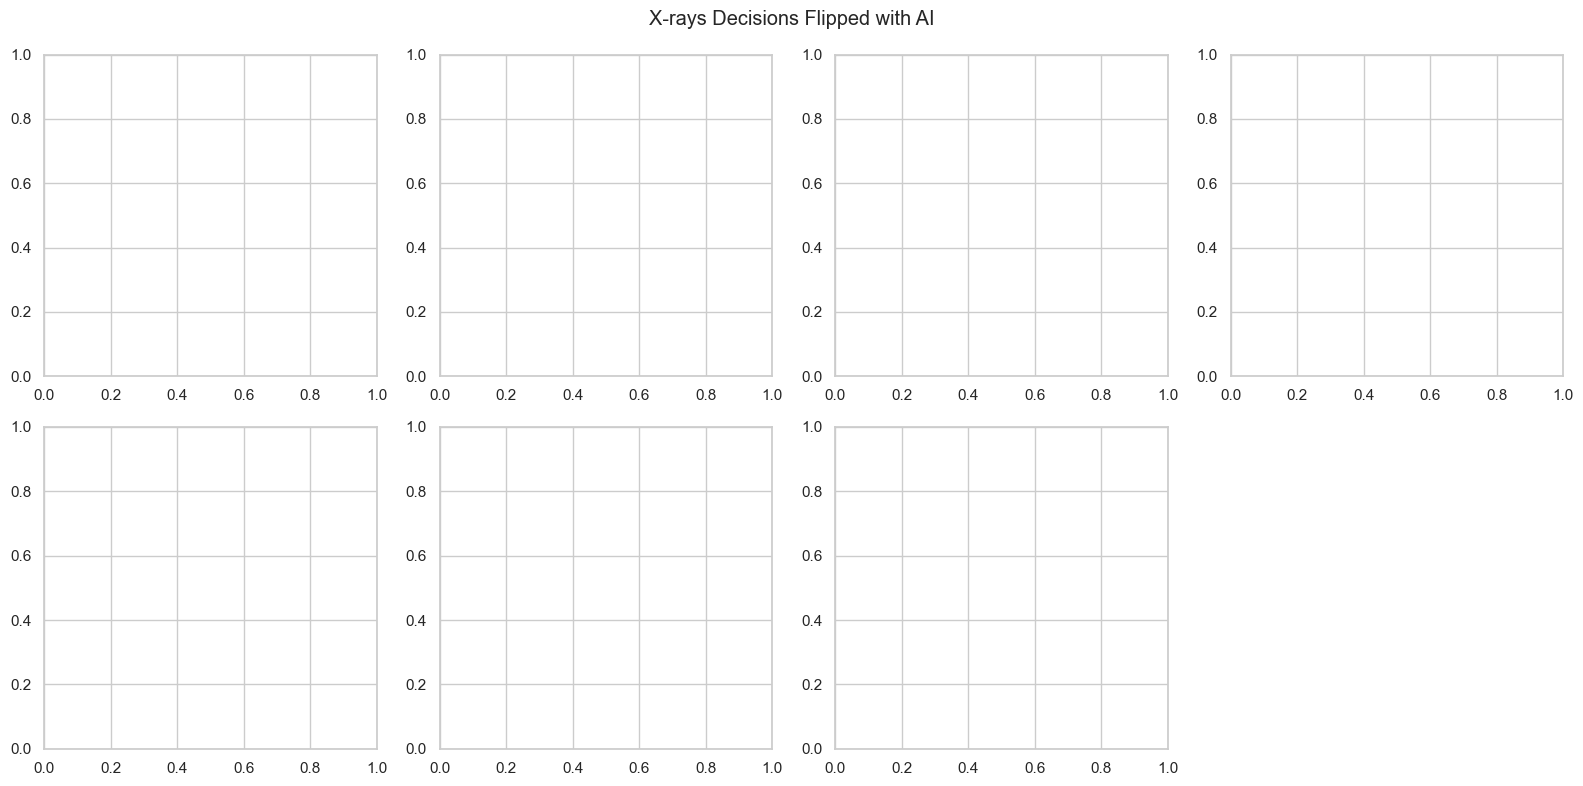

In [35]:
flipped_imgs = {s.id: get_image(s.id) for _, s in flipped_df[or_cond_f].iterrows()}

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for ax, (id, img) in zip(axes.flatten(), flipped_imgs.items()):
    ax.imshow(img)
    print(id)
    model = CLASSES[df_xai_samples.loc[df_xai_samples['id'] == id, 'pred'].values[0]]
    actual = CLASSES[df_xai_samples.loc[df_xai_samples['id'] == id, 'ill'].values[0]]
    ax.set_title(f'Model: {model} | Actual: {actual}')
    ax.axis('off')
axes.flatten()[-1].axis('off')
plt.suptitle('X-rays Decisions Flipped with AI')
plt.tight_layout()

In [36]:
most_ur_images = df_ur[df_ur['count'] > 0]
ur_imgs = {s.id: get_image(s.id) for _, s in most_ur_images.iterrows()}
len(ur_imgs)

1

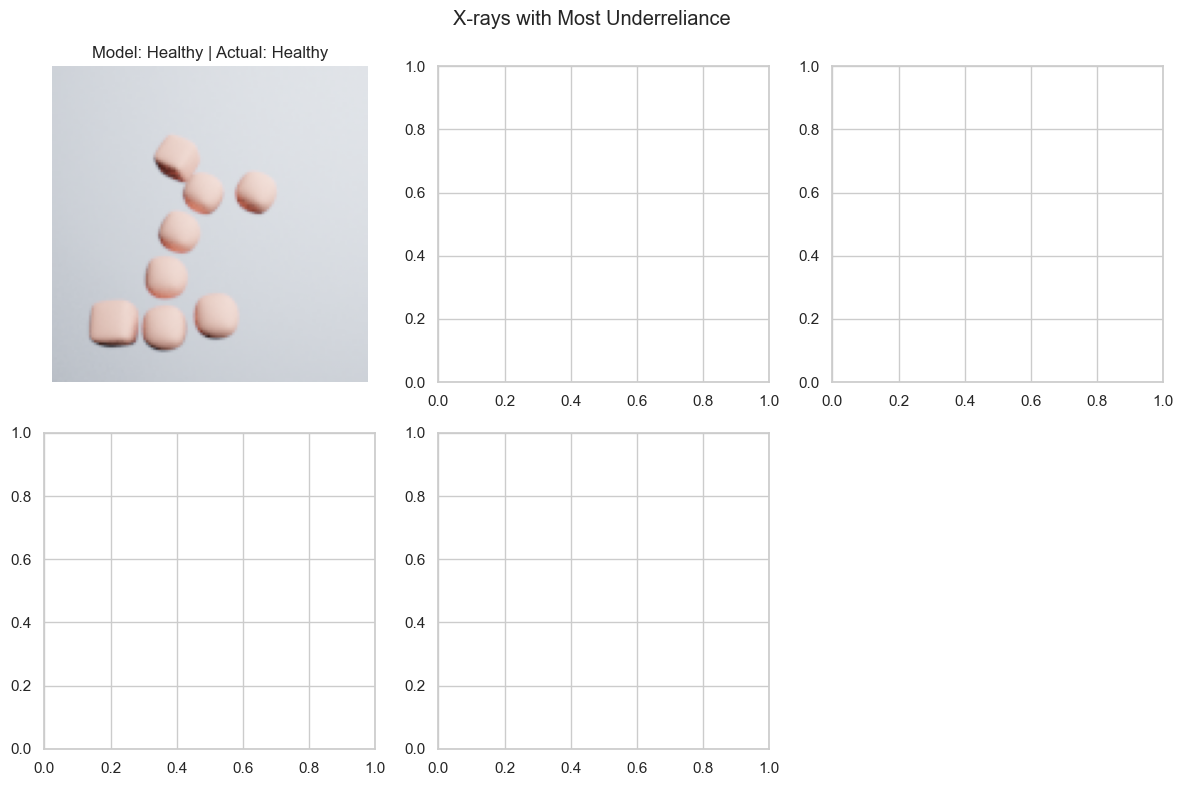

In [37]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for ax, (id, img) in zip(axes.flatten(), ur_imgs.items()):
    ax.imshow(img)
    # user = df_xai_samples[df_xai_samples['id'] == id]['select']
    model = CLASSES[df_xai_samples.loc[df_xai_samples['id'] == id, 'pred'].values[0]]
    actual = CLASSES[df_xai_samples.loc[df_xai_samples['id'] == id, 'ill'].values[0]]
    ax.set_title(f'Model: {model} | Actual: {actual}')
    ax.axis('off')
axes.flatten()[-1].axis('off')
plt.suptitle('X-rays with Most Underreliance')
plt.tight_layout()

In [38]:
most_hd_images = df_hd[df_hd['count'] > 0]
hd_imgs = {s.id: get_image(s.id) for _, s in most_hd_images.iterrows()}
len(hd_imgs)

7

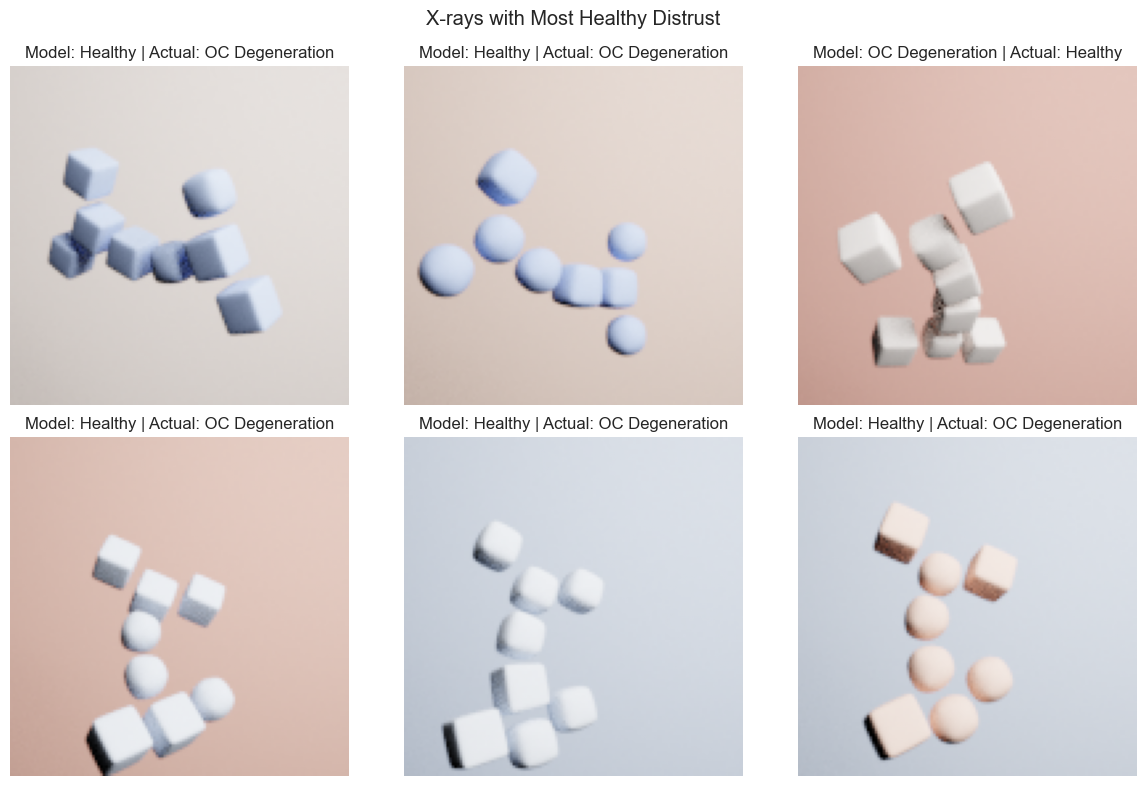

In [39]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for ax, (id, img) in zip(axes.flatten(), hd_imgs.items()):
    ax.imshow(img)
    # user = df_xai_samples[df_xai_samples['id'] == id]['select']
    model = CLASSES[df_xai_samples.loc[df_xai_samples['id'] == id, 'pred'].values[0]]
    actual = CLASSES[df_xai_samples.loc[df_xai_samples['id'] == id, 'ill'].values[0]]
    ax.set_title(f'Model: {model} | Actual: {actual}')
    ax.axis('off')
axes.flatten()[-1].axis('off')
plt.suptitle('X-rays with Most Healthy Distrust')
plt.tight_layout()

In [40]:
most_ht_images = df_ht[df_ht['count'] > 0]
ht_imgs = {s.id: get_image(s.id) for _, s in most_ht_images.iterrows()}
len(ht_imgs)

27

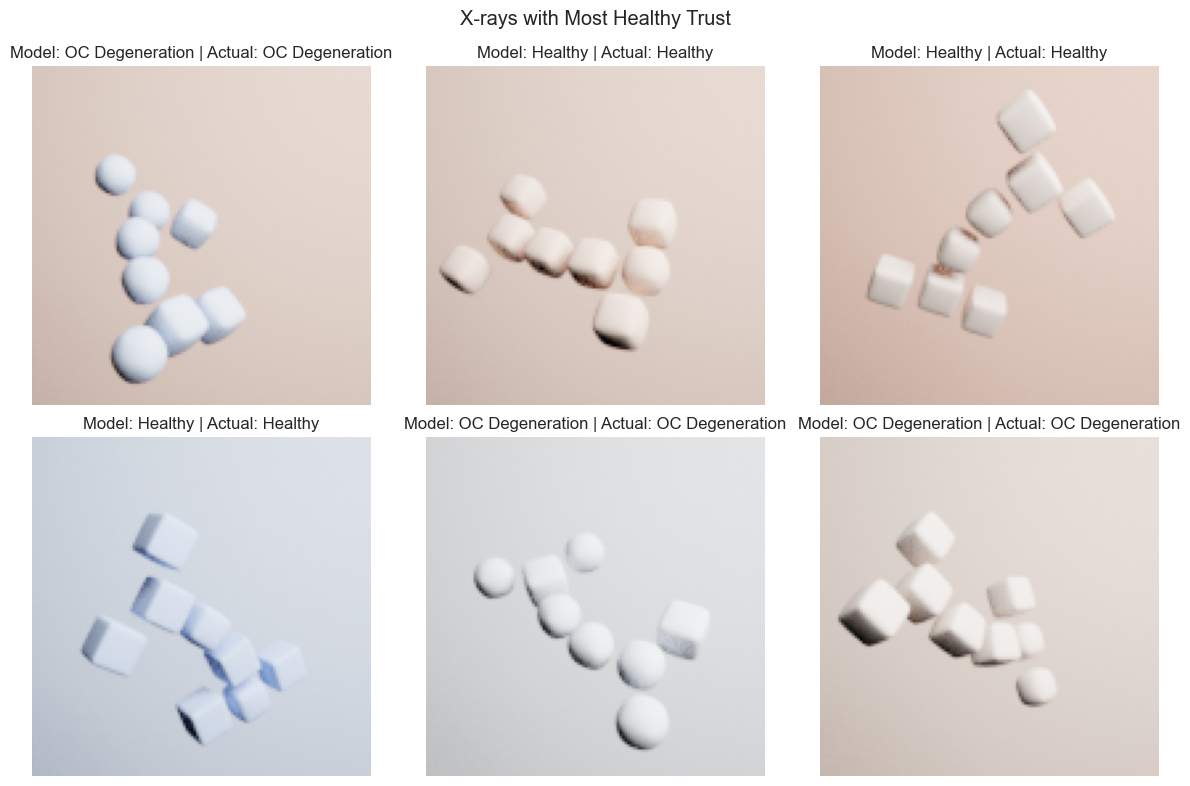

In [41]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for ax, (id, img) in zip(axes.flatten(), ht_imgs.items()):
    ax.imshow(img)
    # user = df_xai_samples[df_xai_samples['id'] == id]['select']
    model = CLASSES[df_xai_samples.loc[df_xai_samples['id'] == id, 'pred'].values[0]]
    actual = CLASSES[df_xai_samples.loc[df_xai_samples['id'] == id, 'ill'].values[0]]
    ax.set_title(f'Model: {model} | Actual: {actual}')
    ax.axis('off')
axes.flatten()[-1].axis('off')
plt.suptitle('X-rays with Most Healthy Trust')
plt.tight_layout()

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [47]:
def plot_cms(df_ai, df_noai, cond, name):

  if cond is None:
    cond = [True] * len(df_ai)

  ids, uids = df_ai[cond]['id'], df_ai[cond]['userid']
  rows = []
  for id, uid in zip(ids, uids):
    rows.append(df_noai[(df_noai['id']==id) & (df_noai['userid']==uid)])
  df_noai_cond = pd.concat(rows)

  cm_noai = confusion_matrix(df_noai_cond['true'], df_noai_cond['select'])
  cm_ai = confusion_matrix(df_ai[cond]['true'], df_ai[cond]['select'])

  maxlim = max(cm_noai.max(), cm_ai.max())

  fig, axes = plt.subplots(2, 1, figsize=(6, 10))

  disp = ConfusionMatrixDisplay(cm_noai, display_labels=CLASSES)
  disp.plot(cmap='Blues', ax = axes[0], colorbar=False)
  axes[0].grid(False)
  axes[0].set_title('User Diagnoses - No AI')
  axes[0].set_xticklabels([])
  axes[0].set_xlabel("")
  axes[0].set_yticklabels(CLASSES, rotation=90,  ha='right', va='center')
  im = axes[0].images[0]
  im.set_clim(0, maxlim) 

  disp = ConfusionMatrixDisplay(cm_ai, display_labels=CLASSES)
  disp.plot(cmap='Blues', ax = axes[1], colorbar=False)
  axes[1].grid(False)
  axes[1].set_yticklabels(CLASSES, rotation=90, ha='right', va='center')
  axes[1].set_title('User Diagnoses - With AI')
  im = axes[1].images[0]
  im.set_clim(0, maxlim) 

  plt.suptitle(f'User Diagnoses - {name}')
  plt.tight_layout()

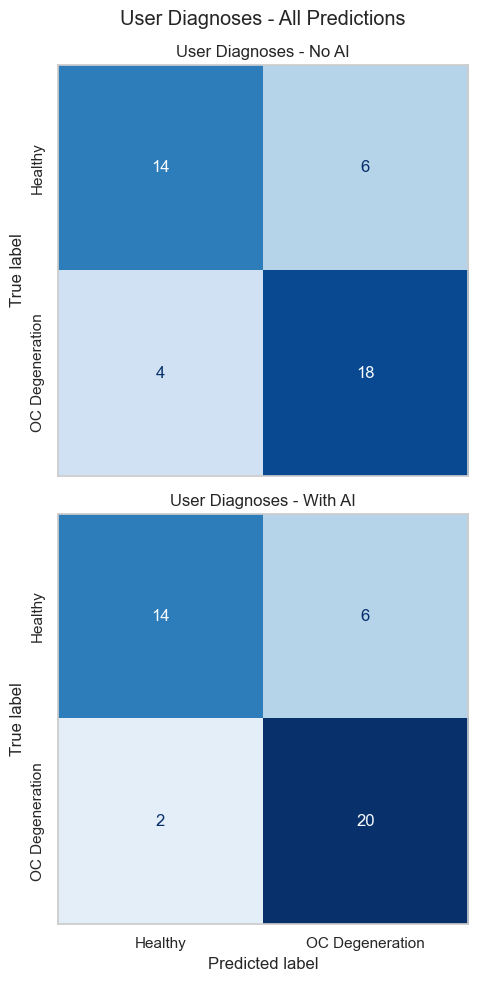

In [48]:
plot_cms(df_ai, df_noai, None, 'All Predictions')

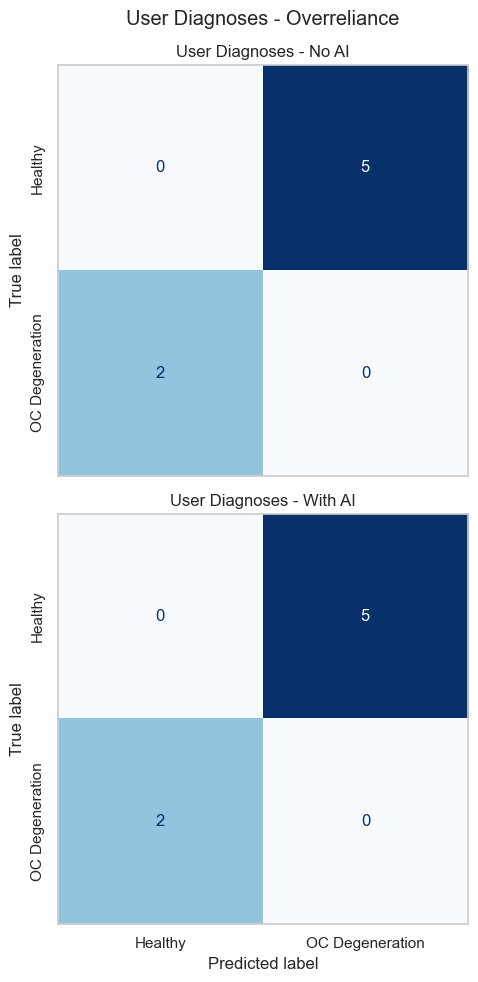

In [44]:
plot_cms(df_ai, df_noai, or_cond, 'Overreliance')

/Users/djohnson/micromamba/envs/evalxai_studies_new/lib/python3.10/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number of labels (2).

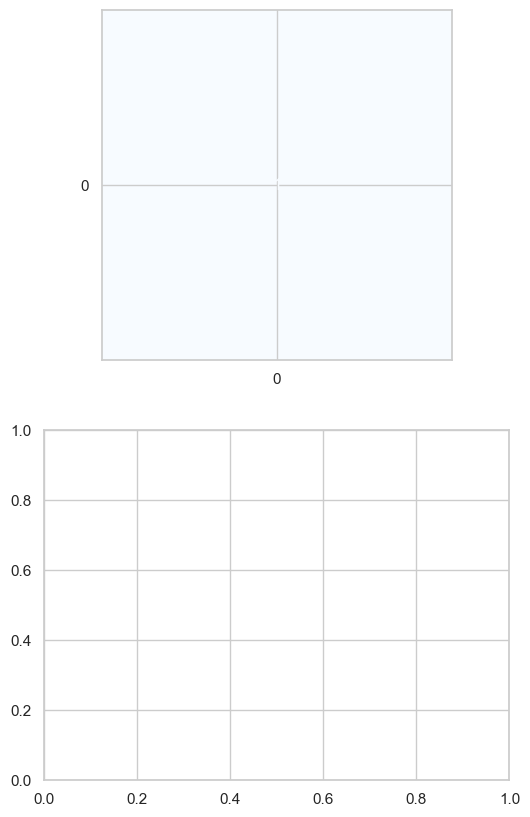

In [45]:
plot_cms(df_ai, df_noai, ur_cond, 'Underreliance')

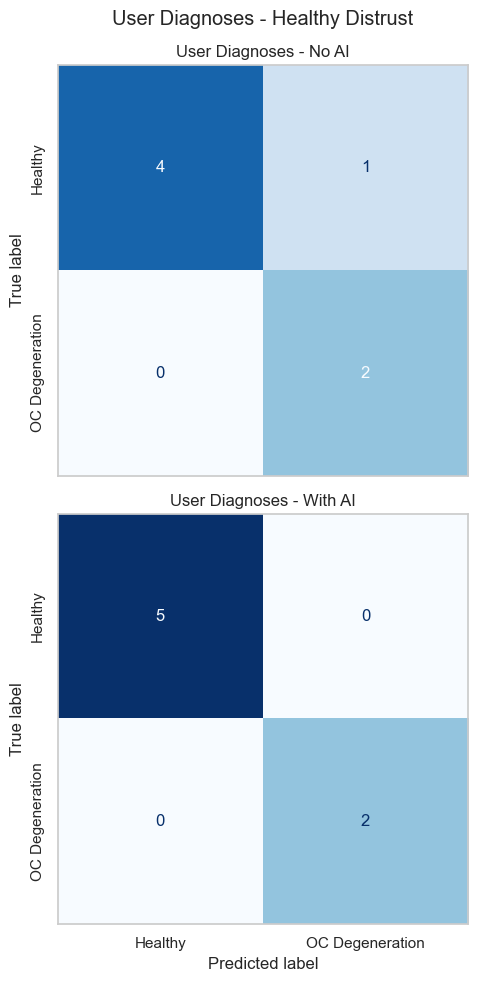

In [ ]:
plot_cms(df_ai, df_noai, hd_cond, 'Healthy Distrust')

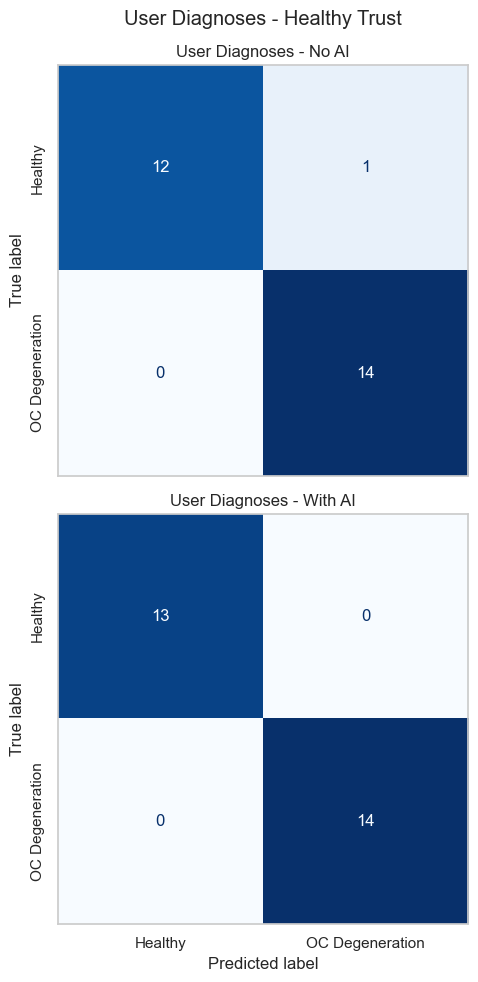

In [46]:
plot_cms(df_ai, df_noai, ht_cond, 'Healthy Trust')